In [1]:
import numpy as np
np.random.seed(1018)
import matplotlib.pyplot as plt
import random as rm
import pandas as pd
from sklearn import preprocessing
from keras.layers import TimeDistributed,Dense,GRU,Dropout,LSTM,Activation
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam,RMSprop


TIME_STEPS = 32
BATCH_SIZE = 20
CELL_SIZE = 128

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


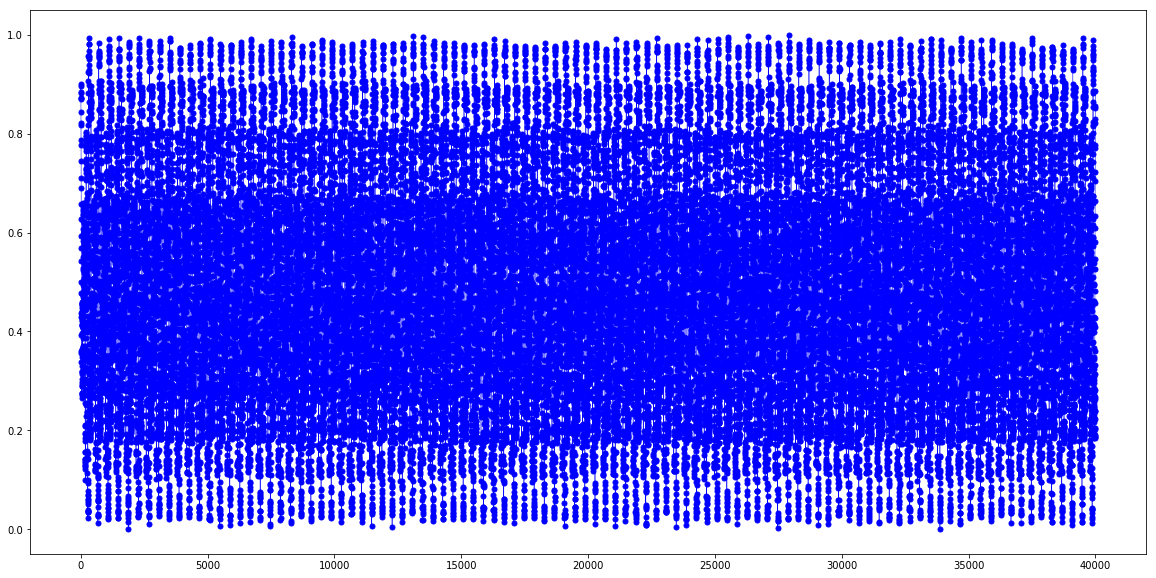

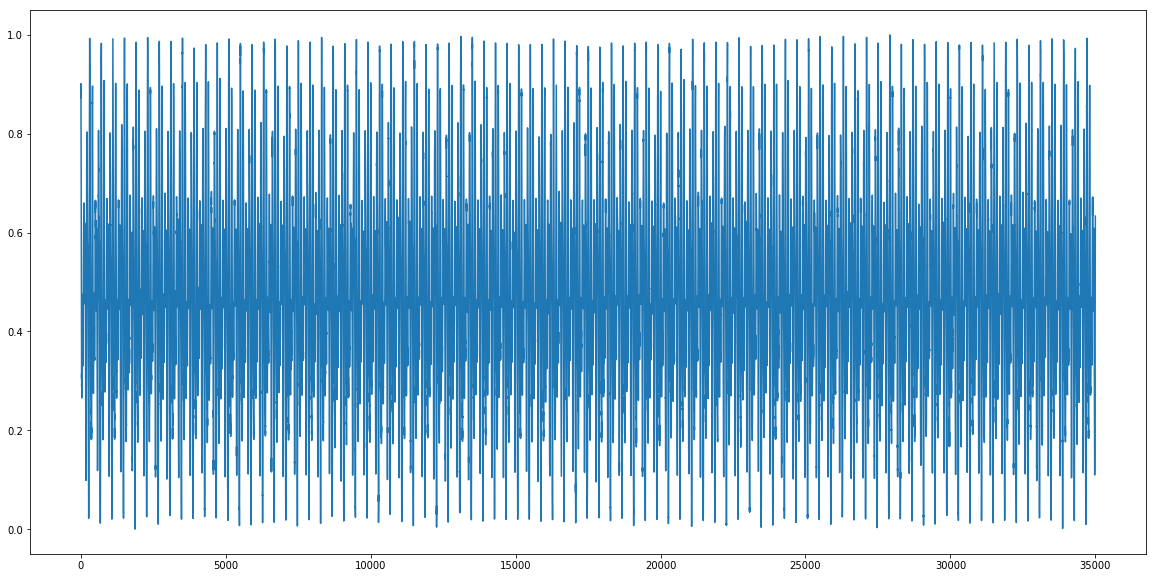

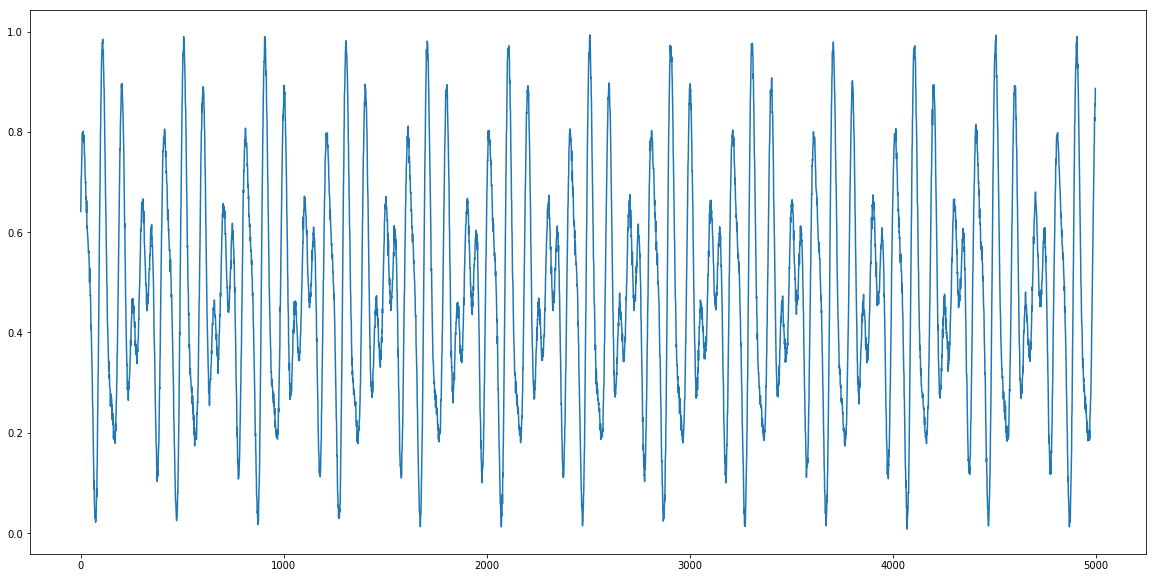

In [2]:
x = np.arange(40000)
noise = np.random.uniform(0,0.1,x.shape)+np.random.normal(0,0.05,x.shape)
y = np.sin(np.pi*x/50)+np.sin(np.pi*x/25)+np.cos(np.pi*x/50)+np.sin(np.pi*x/40+np.pi*3/4) +np.cos(np.pi*x/25+np.pi/4)+noise
# y = noise+np.sin(np.pi*x/50)+noise
dataset = y.reshape(-1,1)
data_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
dataset = data_scaler.fit_transform(y.reshape(-1, 1))
plt.figure(figsize=(20,10))
plt.plot(dataset,"bo-",linewidth=0.5, markersize=5)
plt.show()
train = dataset[0:35000]
test = dataset[35000:40000]
plt.figure(figsize=(20,10))
plt.plot(train)
plt.show()
plt.figure(figsize=(20,10))
plt.plot(test)
plt.show()

In [3]:
# plt.figure(figsize=(20,10))
# plt.plot(train[:9000])
# plt.show()

In [4]:
data_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
dataset = data_scaler.fit_transform(dataset)
dataset = (dataset*1000).astype(np.int32)
print(dataset.shape)
enconder = preprocessing.OneHotEncoder()
enconder.fit(dataset)
dataset = enconder.transform(dataset).toarray()

(40000, 1)


In [5]:
dataset.shape

(40000, 998)

In [6]:
train = dataset[0:35000]
test = dataset[35000:40000]

In [7]:
train.shape

(35000, 998)

In [8]:
def GetBatch(data,TIME_STEPS):
    data_X = []
    data_y = []
    for INDEX in range(0,len(data)-TIME_STEPS):
        X_step = data[INDEX:INDEX+TIME_STEPS,:]
        y_step = data [INDEX+TIME_STEPS,:]
        data_X.append(X_step)
        data_y.append(y_step)
    return np.array(data_X),np.array(data_y)

In [9]:
trainX,trainy = GetBatch(train,TIME_STEPS)
testX,testy = GetBatch(test,TIME_STEPS)

In [10]:
trainX.shape

(34968, 32, 998)

In [11]:
1 in trainX[2][19]

True

In [12]:
trainX[2][19] == trainy[1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [13]:
False in (trainX[2][19] == trainy[1])

True

In [14]:
trainy.shape[1]

998

In [15]:
model = Sequential()
model.add(LSTM(CELL_SIZE, input_shape=(TIME_STEPS, train.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [16]:
model.fit(trainX, trainy, batch_size=BATCH_SIZE,epochs=6)

Epoch 1/6
34968/34968 [==============================] - 124s 4ms/step - loss: 5.8799
Epoch 2/6
34968/34968 [==============================] - 121s 3ms/step - loss: 4.6719
Epoch 3/6
34968/34968 [==============================] - 116s 3ms/step - loss: 4.3334
Epoch 4/6
34968/34968 [==============================] - 117s 3ms/step - loss: 4.1782
Epoch 5/6
34968/34968 [==============================] - 114s 3ms/step - loss: 4.0648
Epoch 6/6
34968/34968 [==============================] - 112s 3ms/step - loss: 3.9862


In [30]:
model.save('sin+noise_oe.h5')

In [15]:
from keras.models import load_model
model = load_model('sin+noise_oe.h5')

In [17]:
def prediction(batch_size,time_step,X_test):
    X_test = X_test.reshape(-1,X_test.shape[0],X_test.shape[1])
    y_pred = model.predict(X_test, batch_size=batch_size)
    return y_pred

In [18]:
predictions = []
for num in testX[0].squeeze():
    predictions.append(num.tolist())
y_pred = testy[0]

In [19]:
for i in range(1,4900):
    y_pred = prediction(BATCH_SIZE,TIME_STEPS,np.array(predictions[-TIME_STEPS::]))
    predictions.append(y_pred.squeeze().tolist())

In [20]:
len(predictions)

4931

In [21]:
len(predictions[0])

998

In [22]:
sequence = np.argmax(predictions, axis=1)/1000

In [23]:
sequence.shape

(4931,)

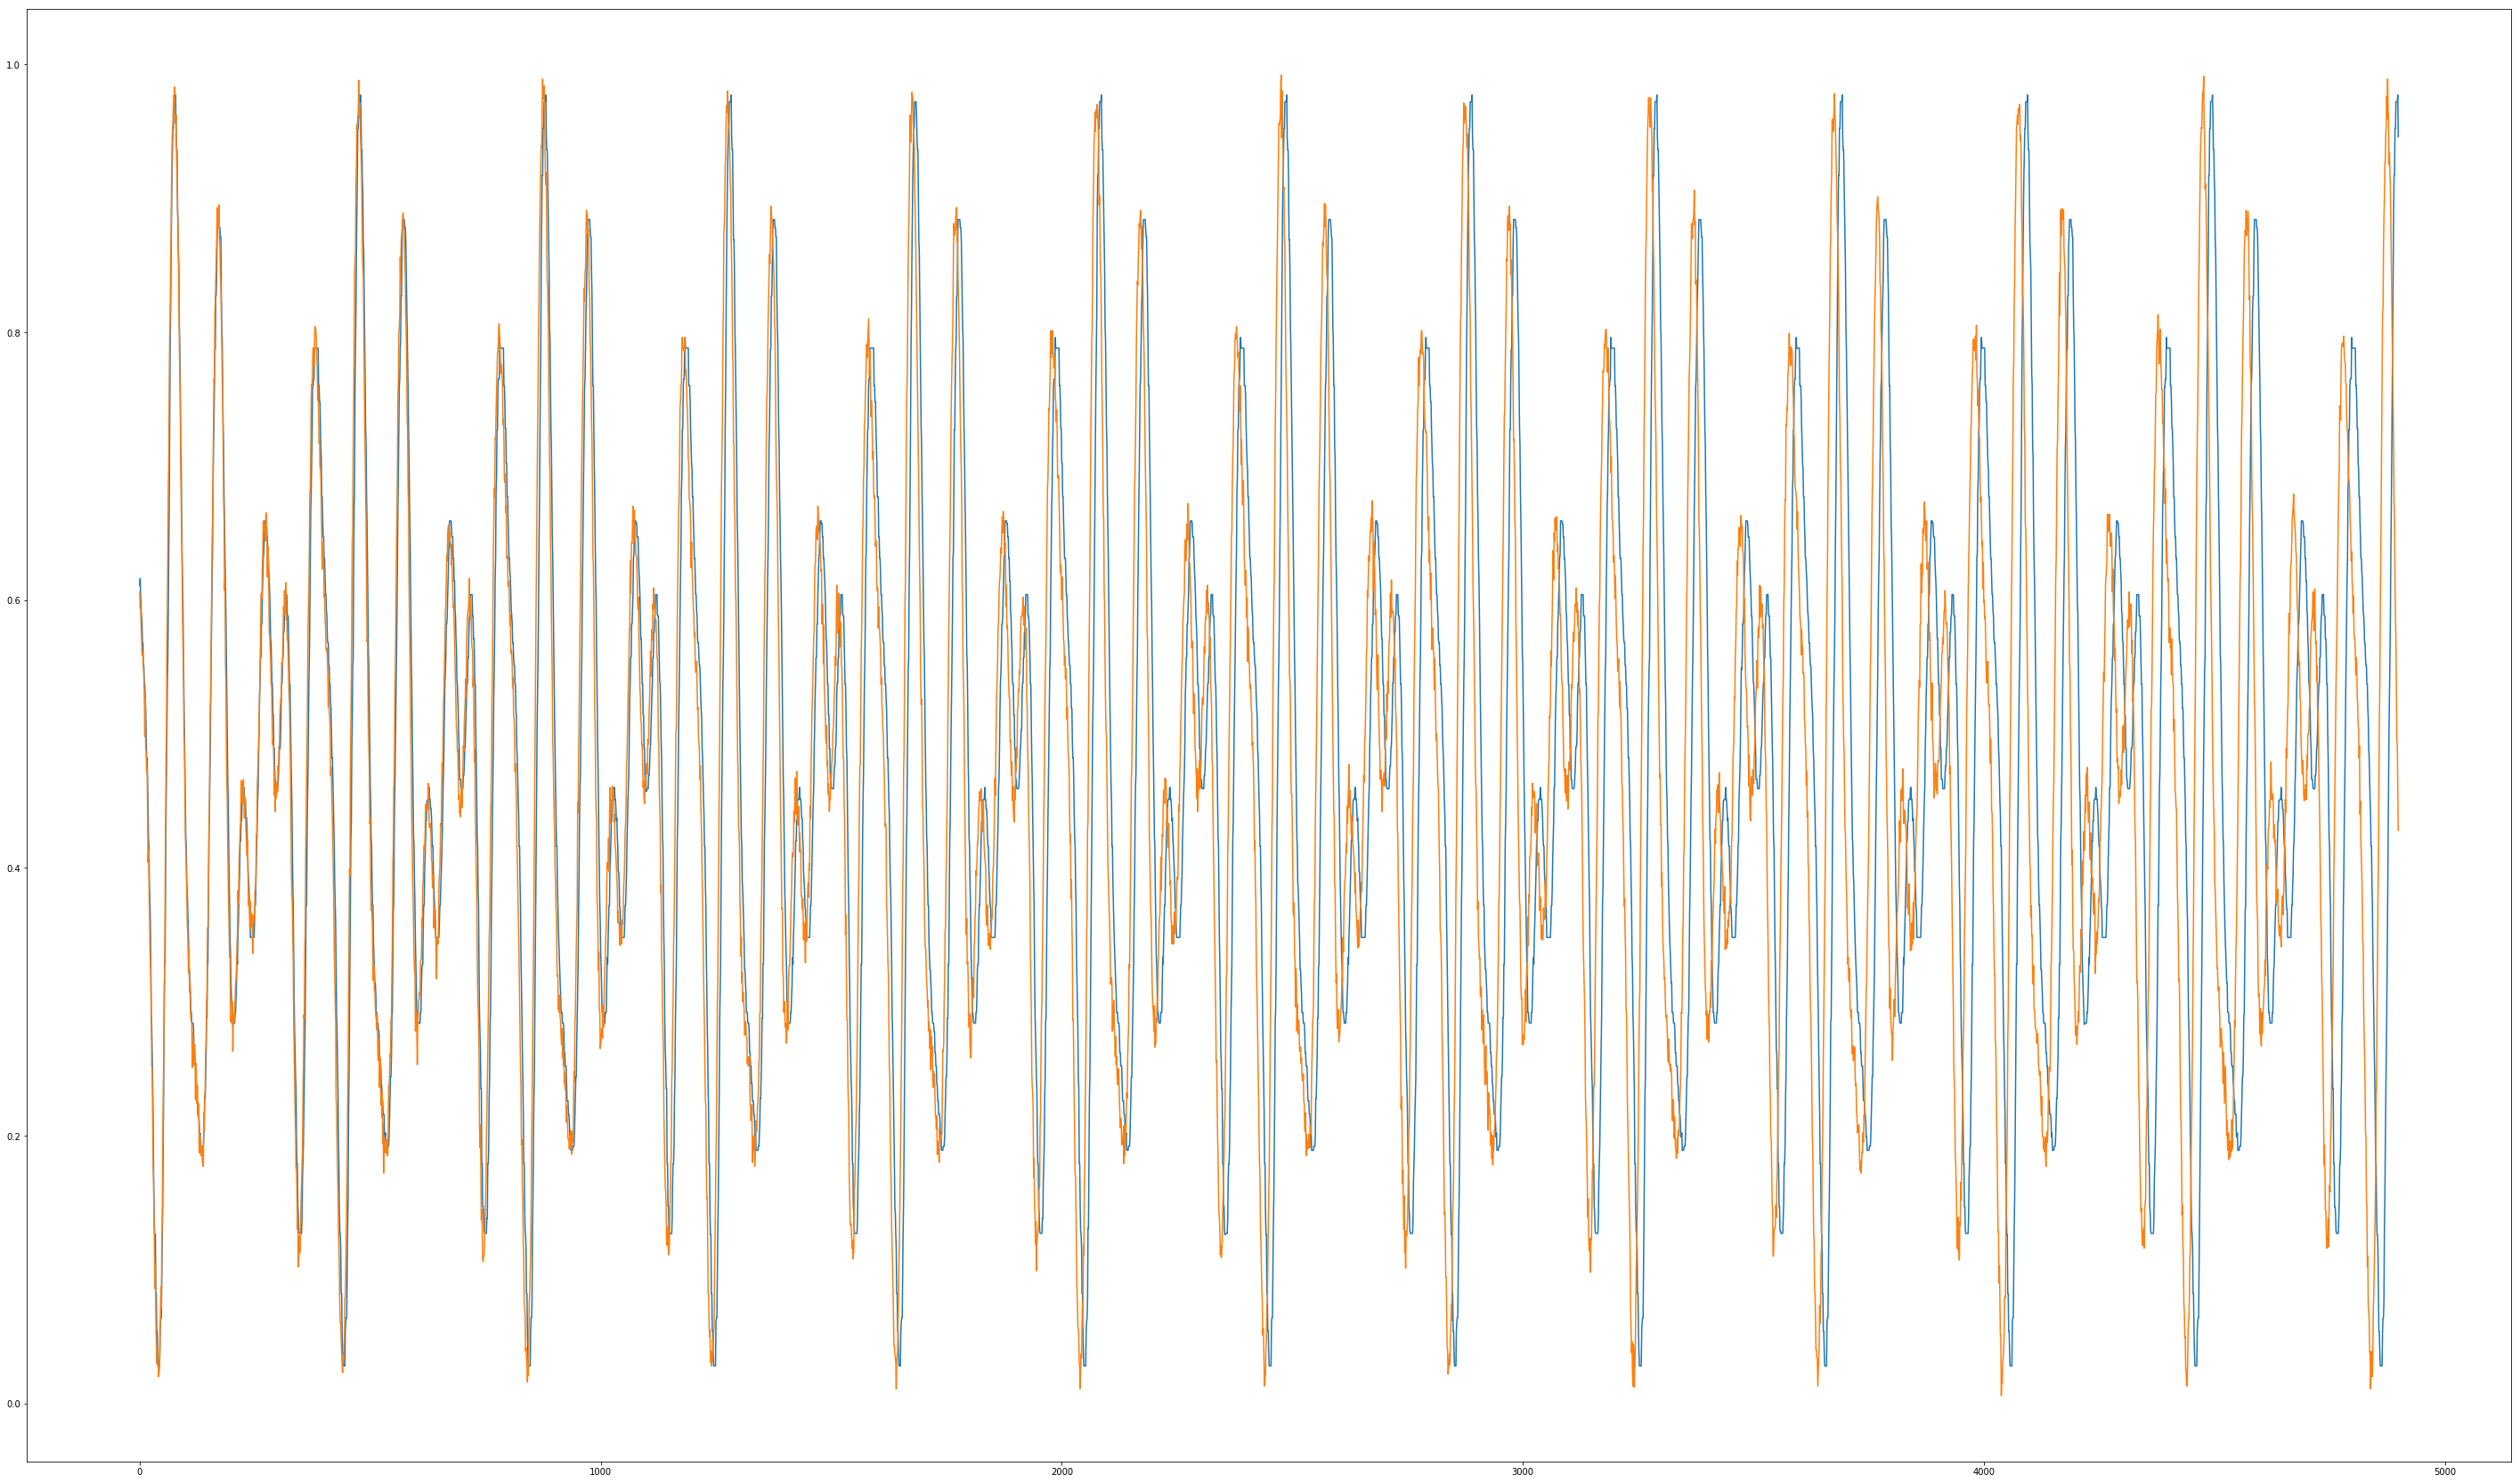

In [24]:
plt.figure(figsize=(50,30))
plt.plot(sequence[-4900::])
plt.plot(np.argmax(testy[:4900],axis=1)/1000)
plt.show()

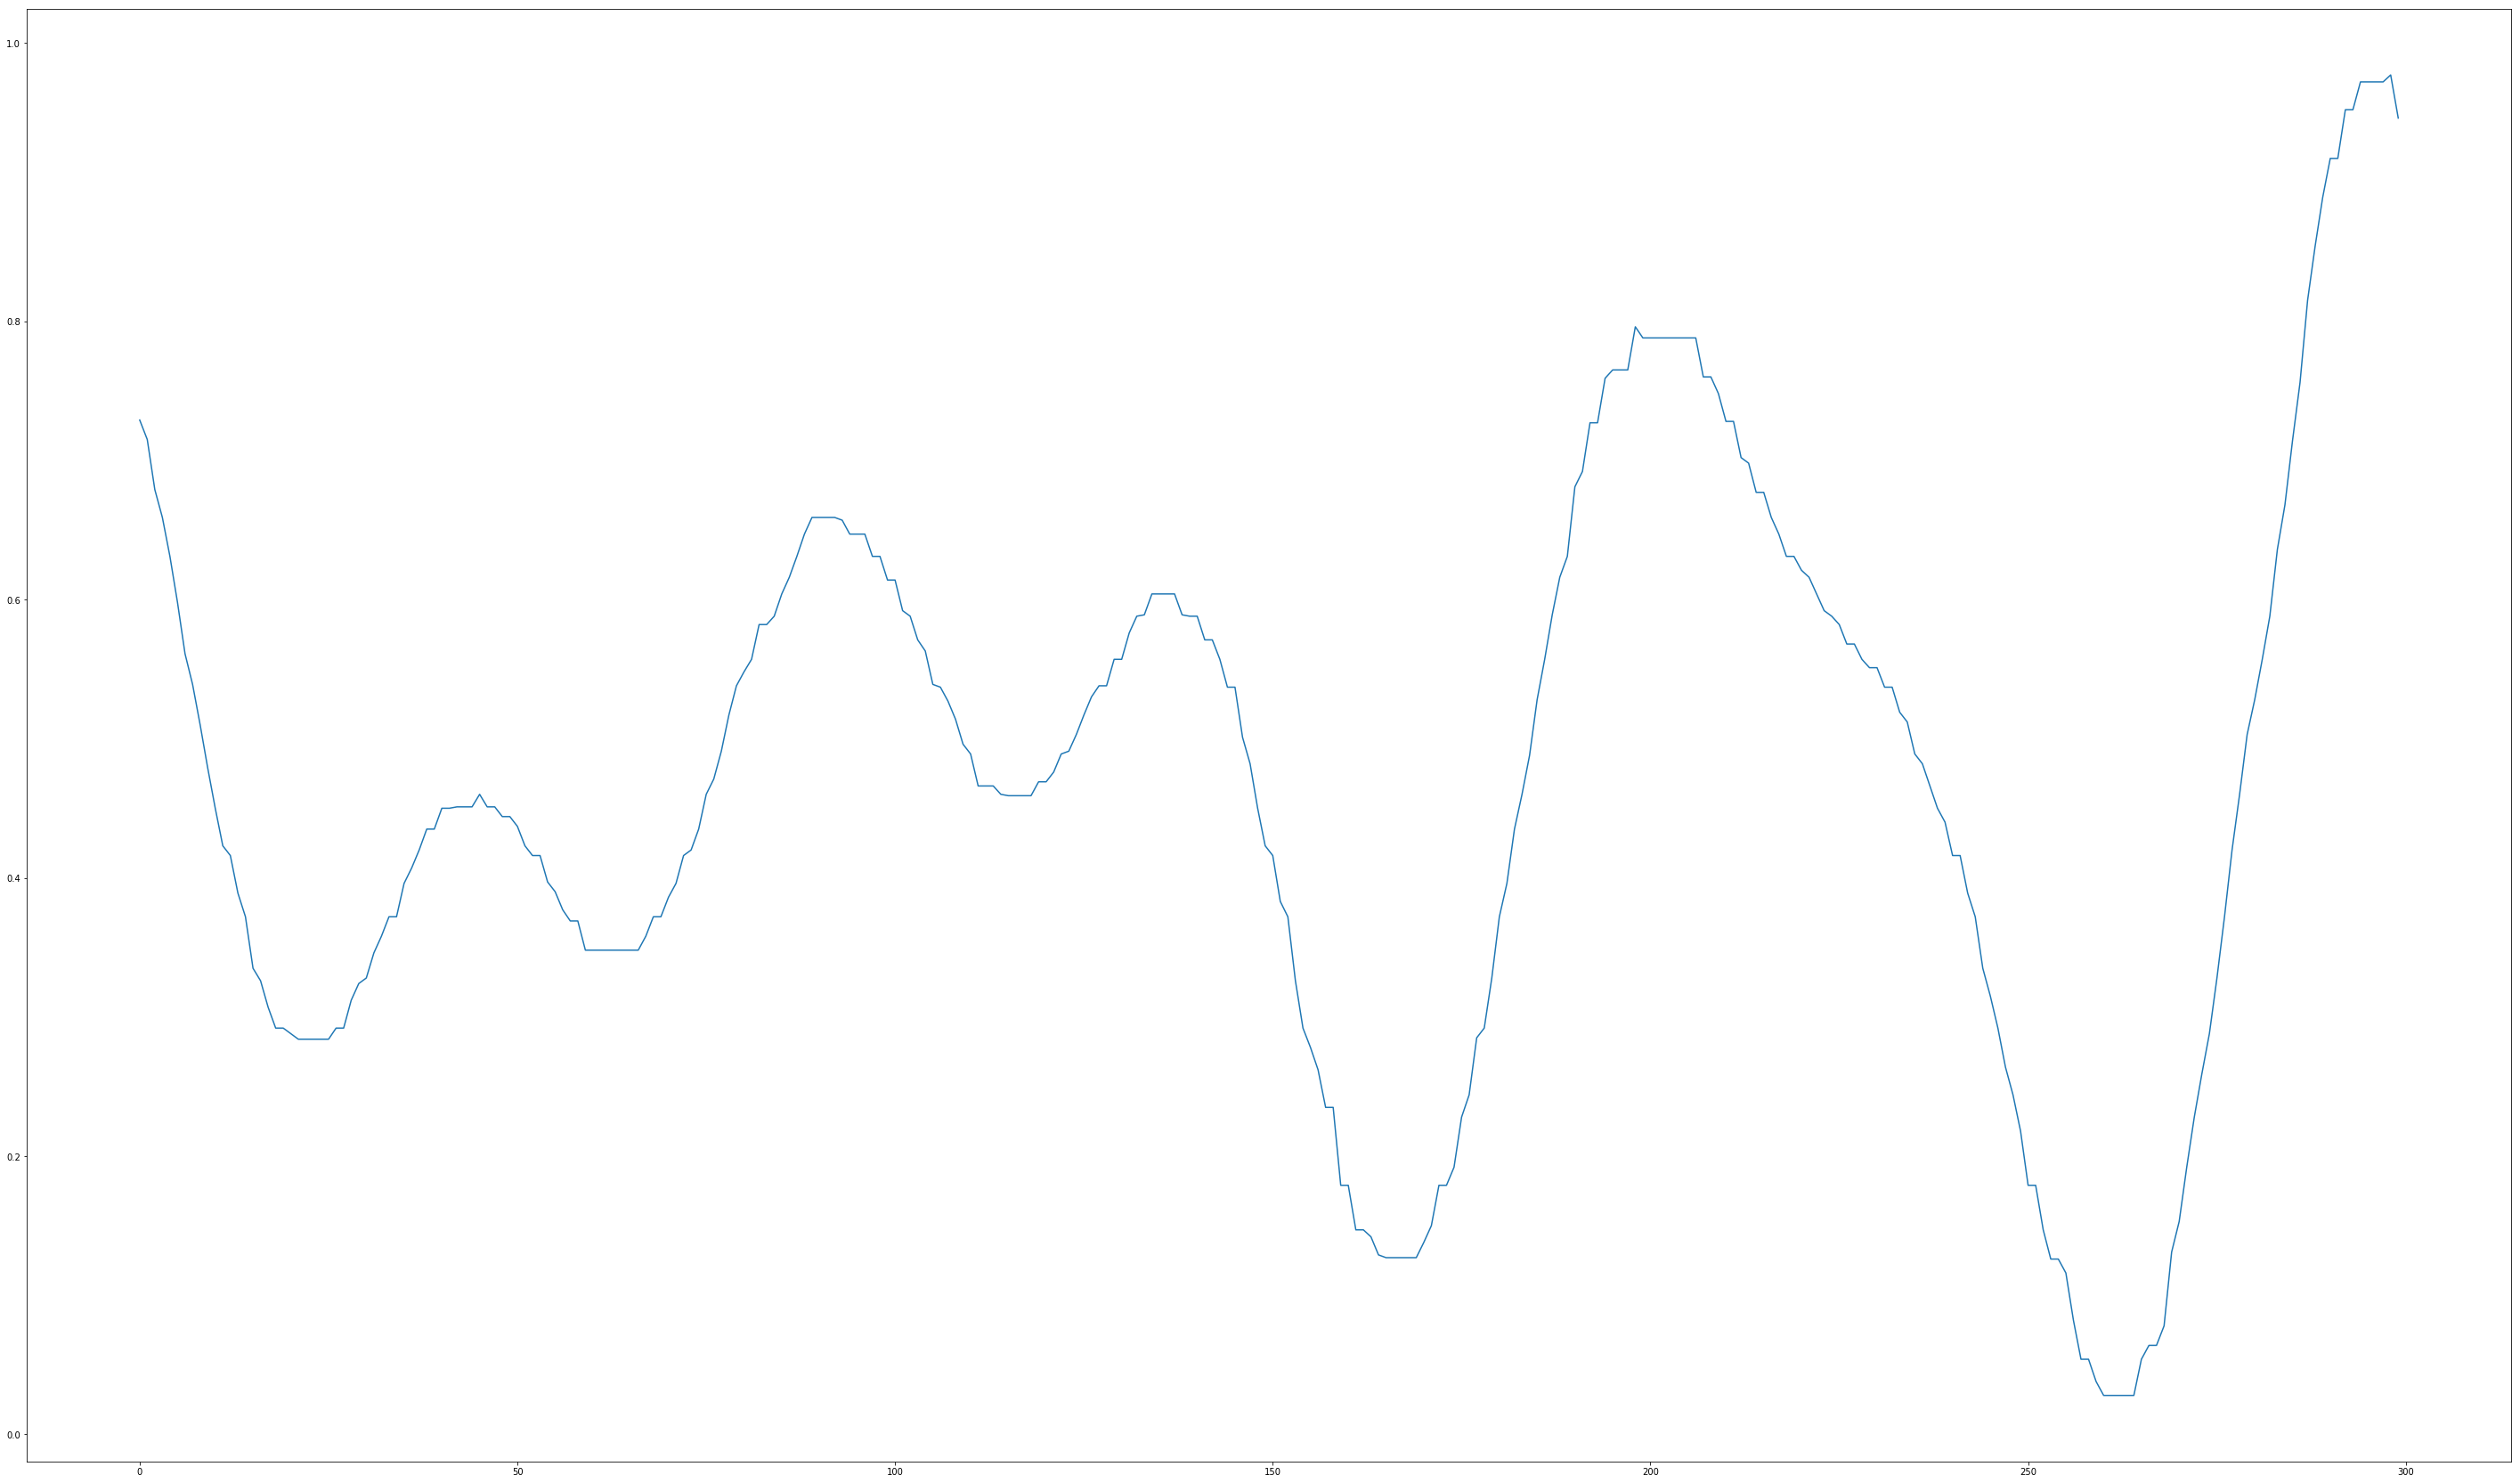

In [26]:
plt.figure(figsize=(50,30))
plt.plot(sequence[-300::])
# plt.plot(np.argmax(testy[:300],axis=1)/1000)
plt.show()